In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_20432\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# disable pandas display truncation, show neighborhood 'Blueste', which has only two values
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# filter and display as df
blueste_df = df[df['Neighborhood'] == 'Blueste']
display(blueste_df)

# reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# drop Blueste
print(len(df))
df.drop(df[df['Neighborhood'] == 'Blueste'].index, inplace=True)
print(len(df))


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
599,600,160,RM,24.0,1950,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,Twnhs,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,CBlock,Gd,TA,No,LwQ,81,GLQ,612,23,716,GasA,TA,Y,SBrkr,716,840,0,1556,1,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1980.0,Fin,2,452,TA,TA,Y,161,0,0,0,0,0,NaN,GdPrv,NaN,0,7,2008,COD,Normal,151000
956,957,160,RM,24.0,1300,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,TwnhsE,2Story,6,6,1980,1980,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,No,ALQ,285,Unf,0,276,561,GasA,TA,Y,SBrkr,561,668,0,1229,0,0,1,1,2,1,TA,5,Typ,1,TA,Attchd,1980.0,Fin,2,462,TA,TA,Y,150,0,0,0,0,0,NaN,GdPrv,NaN,0,5,2009,WD,Normal,124000


1460
1458


what's going on here? it's the neighborhood with only two values, and it freaks out the scaler. something is wrong. i'm dropping this neighborhood

In [4]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [5]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [6]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df = df[['OverallQual', 'OverallCond', 'GrLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'SaleCondition', 'SalePrice']]
df.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SaleCondition,SalePrice
0,7,5,1710,8,2003,Normal,208500
1,6,8,1262,6,1976,Normal,181500
2,7,5,1786,6,2001,Normal,223500
3,7,5,1717,7,1915,Abnorml,140000
4,8,5,2198,9,2000,Normal,250000


In [8]:
df = df[df['SaleCondition'] == 'Normal']

In [9]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [10]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SalePrice,SaleCondition_Normal
0,7,5,1710,8,2003,208500,True
1,6,8,1262,6,1976,181500,True
2,7,5,1786,6,2001,223500,True
4,8,5,2198,9,2000,250000,True
5,5,5,1362,5,1993,143000,True


SalePrice               1.000000
OverallQual             0.792207
GrLivArea               0.736332
TotRmsAbvGrd            0.528494
YearBuilt               0.504184
OverallCond            -0.050749
SaleCondition_Normal         NaN
Name: SalePrice, dtype: float64


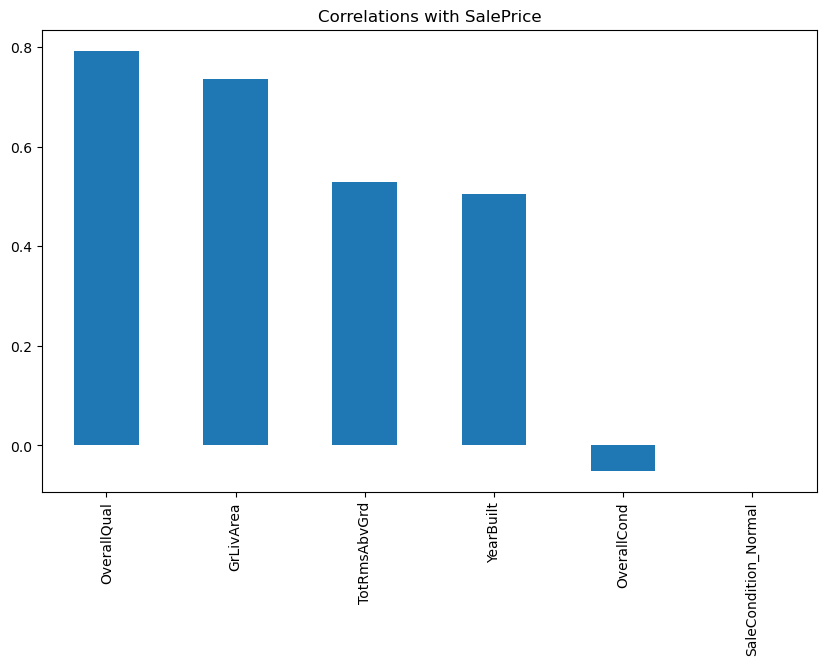

In [11]:
# Calculate correlations
correlations = dummies.corr()['SalePrice'].sort_values(ascending=False)

# Print correlations
print(correlations)

# Plot correlations
plt.figure(figsize=(10, 6))
correlations.drop('SalePrice').plot(kind='bar')
plt.title('Correlations with SalePrice')
plt.show()


In [12]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

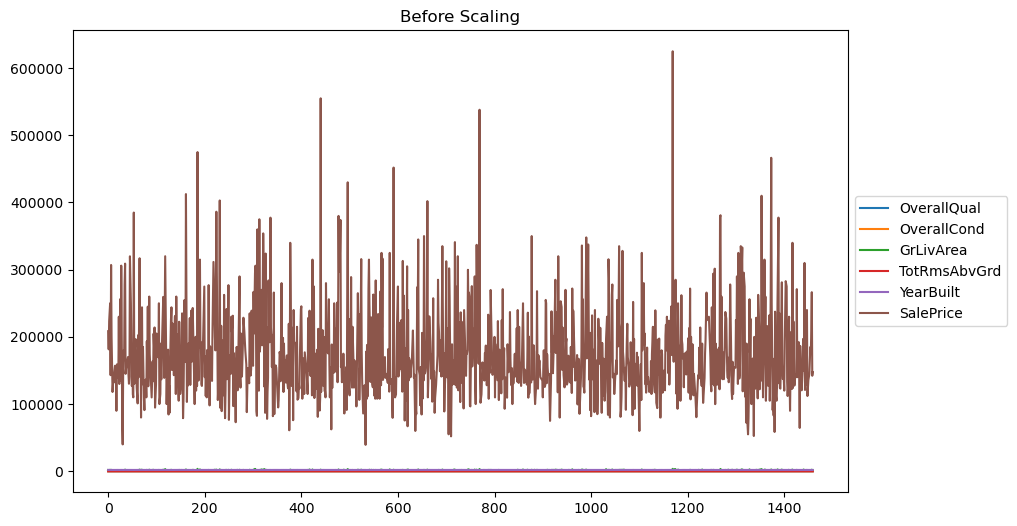

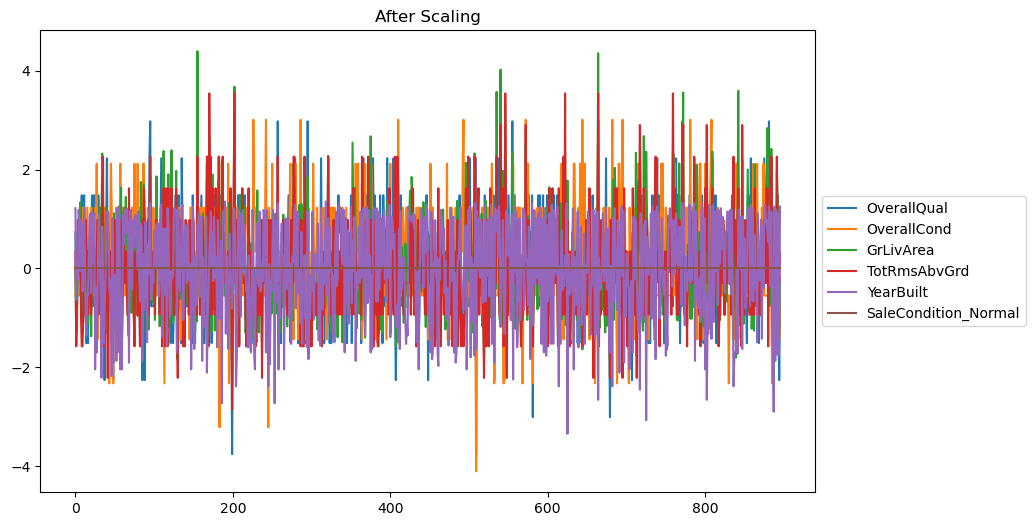

In [13]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

The outlier is in neighborhood

## Compile, Train, Evaluate the Model

In [14]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=4, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=20, max_value=300, step=2),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [15]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 12s]
mae: 175583.15625

Best mae So Far: 17015.42578125
Total elapsed time: 00h 02m 06s


In [16]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 04 summary
Hyperparameters:
num_layers: 4
layer0: 260
activation0: relu
layer1: 138
activation1: tanh
layer2: 82
activation2: LeakyReLU
layer3: 248
activation3: relu
Score: 17015.42578125

Trial 01 summary
Hyperparameters:
num_layers: 3
layer0: 110
activation0: relu
layer1: 192
activation1: LeakyReLU
layer2: 250
activation2: relu
Score: 19625.451171875

Trial 00 summary
Hyperparameters:
num_layers: 3
layer0: 30
activation0: relu
layer1: 20
activation1: relu
layer2: 20
activation2: relu
Score: 24494.34375

Trial 07 summary
Hyperparameters:
num_layers: 3
layer0: 20
activation0: LeakyReLU
layer1: 84
activation1: tanh
layer2: 76
activation2: relu
layer3: 136
activation3: relu
Score: 125806.25

Trial 02 summary
Hyperparameters:
num_layers: 4
layer0: 60
activation0: relu
layer1: 46
activation1: relu
layer2: 50
activation2: tanh
layer3: 20
activation3: relu
Score: 167710.578125



In [17]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)
print("---")

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Best Hyperparameters:
{'num_layers': 4, 'layer0': 260, 'activation0': 'relu', 'layer1': 138, 'activation1': 'tanh', 'layer2': 82, 'activation2': 'LeakyReLU', 'layer3': 248, 'activation3': 'relu'}
---
Epoch 1/100
28/28 [==============================] - 1s 12ms/step - loss: 176378.0781 - mae: 176378.0781 - val_loss: 164010.7500 - val_mae: 164010.7500
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 176115.3906 - mae: 176115.3906 - val_loss: 163406.1719 - val_mae: 163406.1719
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 174953.1406 - mae: 174953.1406 - val_loss: 161500.4688 - val_mae: 161500.4688
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 172030.5000 - mae: 172030.5000 - val_loss: 157291.8281 - val_mae: 157291.8281
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 166253.1562 - mae: 166253.1562 - val_loss: 149624.7656 - val_mae: 149624.7656
Epoch 6/100
28/28 [=========================

In [18]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 260)               1820      
                                                                 
 dense_5 (Dense)             (None, 138)               36018     
                                                                 
 dense_6 (Dense)             (None, 82)                11398     
                                                                 
 dense_7 (Dense)             (None, 248)               20584     
                                                                 
 dense_8 (Dense)             (None, 1)                 249       
                                                                 
Total params: 70069 (273.71 KB)
Trainable params: 70069 (273.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[-0.13231786  0.06652506  0.23967426 ... -0.10163996 -0.11694575
   0.24592088]
 [-0.08439042  0.183369    0.15413931 ...  0.26898023  0.00942155
  -0.13335344]
 [ 0.06867941  0.22706643  0.12278023 ... -0.1422168  -0.19258946
   0.24345051]
 [ 0.2602851   0.17773907  0.11620367 ... -0.2300481   0.08430969
  -0.15213445]
 [-0.20623584 -0.23045553  0.1441372  ... -0.12536088 -0.18024278
   0.18104699]
 [-0.14276928  0.08118987  0.05751058 ... -0.02665344 -0.0098902
   0.01076153]]
Layer 1 Weights:
[0.17044094 0.1718385  0.16980338 0.16363357 0.16792631 0.17123203
 0.15321086 0.18089052 0.16818674 0.15993685 0.16520508 0.15999044
 0.17649885 0.16039549 0.16805951 0.16253552 0.18534455 0.15961489
 0.17321473 0.15260139 0.1769403  0.16184463 0.15336534 0.1633476
 0.16053645 0.16550463 0.1461548  0.15882781 0.15438496 0.16055131
 0.1732385  0.15729716 0.16760913 0.150193   0.18085673 0.1708139
 0.15656598 0.1586785  0.1693019  0.16201408 0.15832692 0.17040806
 0.1720805  0

In [20]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

5/5 [==============================] - 0s 1ms/step


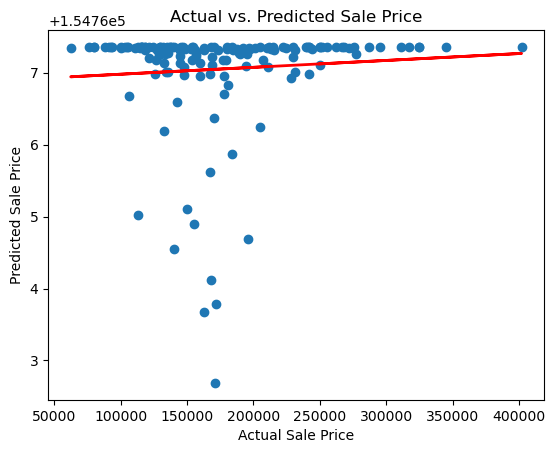

In [21]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [22]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: -0.12073533353037247
Mean Squared Error: 4103838802.296208
Mean Absolute Error: 47661.02291666667
Mean Percentage Error: 1.291409485176351


In [23]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -9.767483872025196e-05
Baseline Mean Squared Error: 3662095341.601121
Baseline Mean Absolute Error: 48139.728422619046
Mean Percentage Error: -12.500385305330964


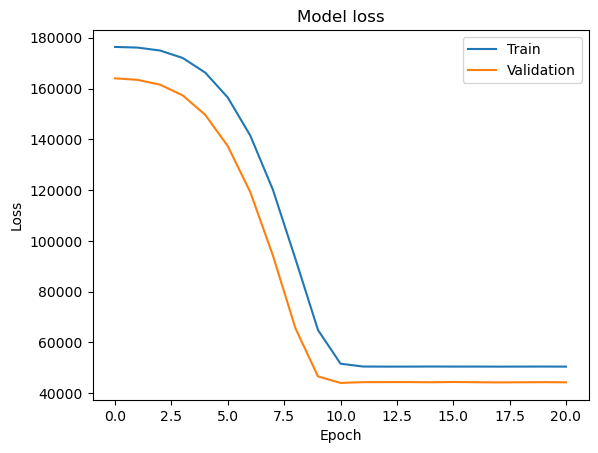

In [24]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

5/5 [==============================] - 0s 2ms/step


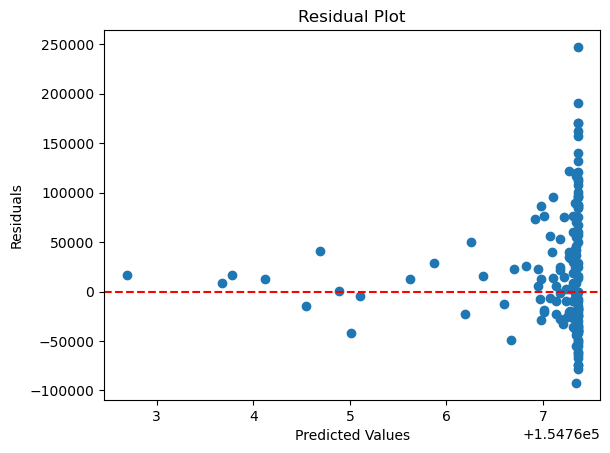

In [25]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

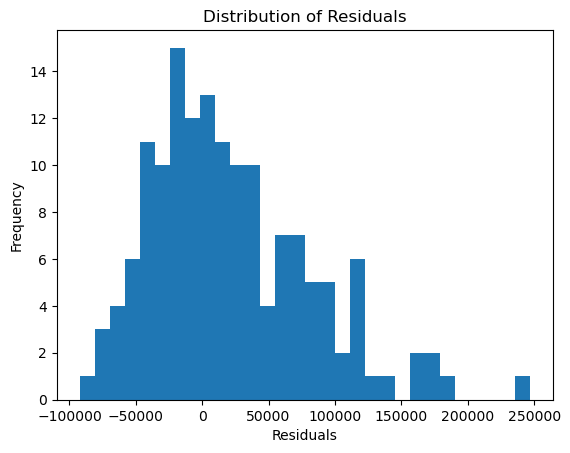

In [26]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [27]:
# plot the learning curve?